# Task 4: Proxy Target Variable Engineering (RFM-Based Risk Labeling)

## Objective
Since direct fraud/default outcomes are either unavailable or extremely sparse,
this task constructs a **proxy supervised learning target** using customer
behavioral segmentation based on **RFM (Recency, Frequency, Monetary) analysis**.

The resulting binary label (`is_high_risk`) is integrated with engineered
features from Task 3 to produce a **modeling-ready analytics base table**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# ensure project root (parent of the notebooks folder) is on sys.path so local 'src' can be imported
sys.path.insert(0, str((Path.cwd() / "..").resolve()))

from src.proxy_target import proxy_target_pipeline

plt.rcParams["figure.figsize"] = (8, 5)
sns.set_style("whitegrid")


In [2]:
# Task 3 outputs
features = pd.read_csv("../data/processed/task-3-features.csv")

# Raw transaction data
transactions = pd.read_csv("../data/raw/data.csv")

transactions["TransactionStartTime"] = pd.to_datetime(
    transactions["TransactionStartTime"]
)

features.head()


,CustomerId,Amount_sum,Amount_mean,Amount_max,Amount_std,Amount_skew,Value_sum,Value_mean,Value_max,Value_std,...,Amount_max_log_std,Amount_skew_log_std,Value_mean_log_std,Value_skew_log_std,Recent30_Amount_sum_log_std,Recent30_Amount_mean_log_std,Recent30_TransactionStartTime_count_log_std,ProductCategory_woe,ChannelId_woe,ProviderId_woe
0,CustomerId_1,-10000.0,-10000.000000,-10000.0,NaN,NaN,10000,10000.000000,10000,NaN,...,NaN,NaN,0.759624,NaN,NaN,NaN,NaN,0.527011,1.091977,0.927025
1,CustomerId_10,-10000.0,-10000.000000,-10000.0,NaN,NaN,10000,10000.000000,10000,NaN,...,NaN,NaN,0.759624,NaN,NaN,NaN,NaN,0.527011,1.091977,0.927025
2,CustomerId_1001,20000.0,4000.000000,10000.0,6558.963333,-0.545422,30400,6080.000000,10000,4100.243895,...,0.131517,-1.143349,0.391925,-1.341493,NaN,NaN,NaN,-0.218502,-0.075480,0.927025
3,CustomerId_1002,4225.0,384.090909,1500.0,560.498966,0.958495,4775,434.090909,1500,518.805446,...,-1.062255,0.346388,-1.557271,0.259315,-1.727572,-1.667262,-0.792125,-0.218502,1.091977,0.927025
4,CustomerId_1003,20000.0,3333.333333,10000.0,6030.478146,-0.098567,32000,5333.333333,10000,3945.461528,...,0.131517,-0.445057,0.295104,-0.240662,-0.007687,0.193369,-0.263726,0.527011,-0.075480,0.537873


### Why a Proxy Target is Needed

The dataset does not contain reliable or sufficiently frequent fraud/default
labels suitable for supervised modeling.

To enable downstream risk modeling, we construct a **proxy target variable**
using **customer behavioral patterns**, following industry-standard
RFM (Recency, Frequency, Monetary) segmentation techniques.

Customers exhibiting **recent inactivity, low engagement, and low monetary value**
are treated as higher risk.


In [3]:
rfm_labeled, features_with_target, cluster_centers = proxy_target_pipeline(
    transactions=transactions,
    feature_df=features
)

rfm_labeled.head()
#features_with_target.head()

Proxy target distribution:
is_high_risk
1    0.618653
0    0.381347
Name: proportion, dtype: float64


,CustomerId,Recency,Frequency,Monetary,cluster,is_high_risk
0,CustomerId_1,83,1,-10000.0,0,0
1,CustomerId_10,83,1,-10000.0,0,0
2,CustomerId_1001,89,5,20000.0,0,0
3,CustomerId_1002,25,11,4225.0,1,1
4,CustomerId_1003,11,6,20000.0,1,1


## RFM Feature Construction

For each customer:
- **Recency**: Days since last transaction (higher = worse)
- **Frequency**: Number of transactions
- **Monetary**: Total transaction amount

A consistent snapshot date (latest transaction date) is used to ensure
recency comparability across customers.


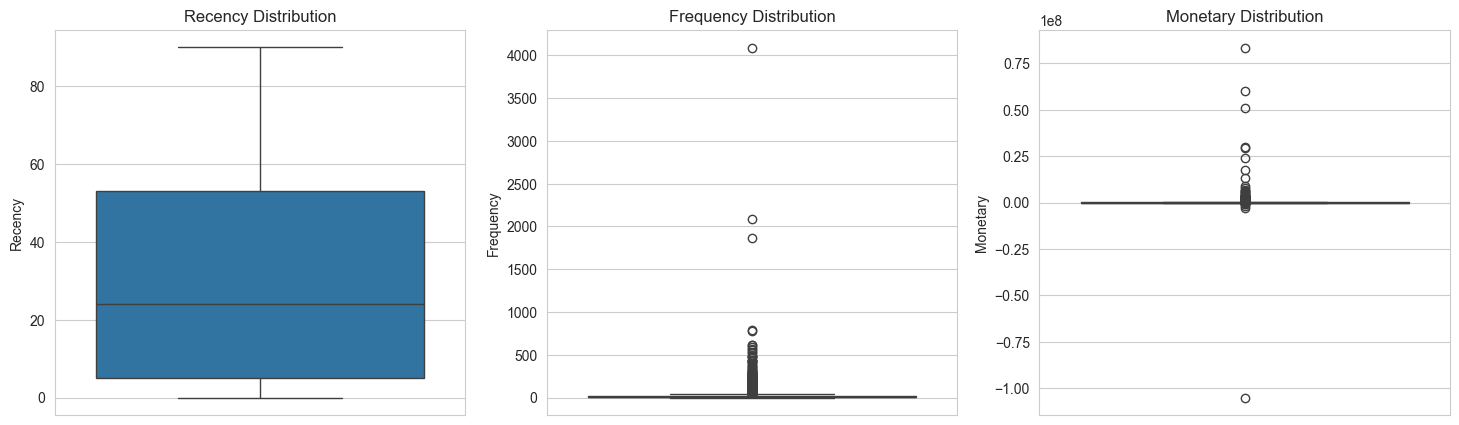

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=rfm_labeled["Recency"], ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.boxplot(y=rfm_labeled["Frequency"], ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.boxplot(y=rfm_labeled["Monetary"], ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.show()


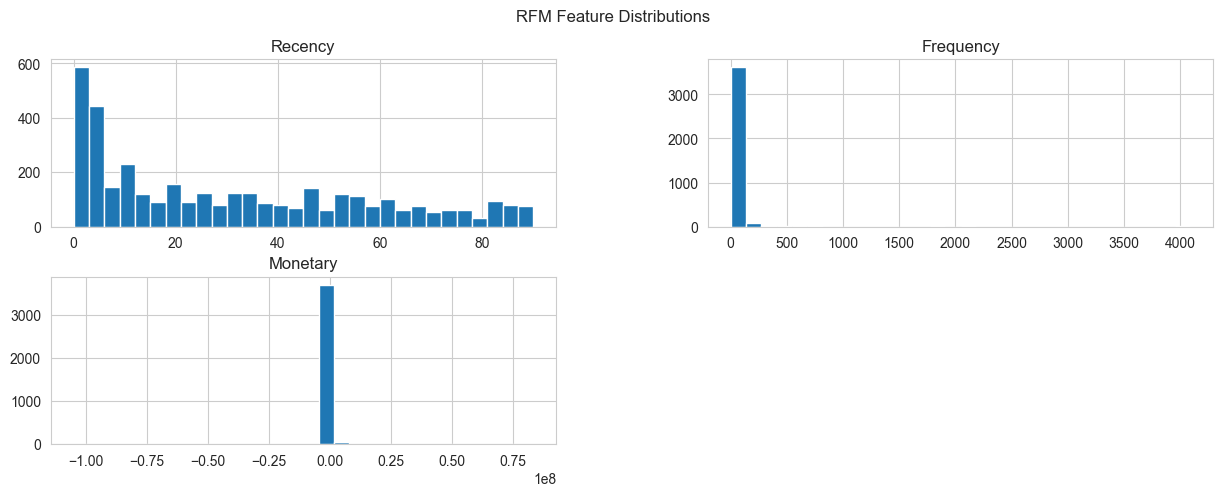

In [5]:
rfm_labeled[["Recency", "Frequency", "Monetary"]].hist(bins=30, figsize=(15, 5))
plt.suptitle("RFM Feature Distributions")
plt.show()


## Behavioral Segmentation via K-Means

RFM features are standardized using `StandardScaler` to ensure equal contribution.
Customers are segmented using **K-Means clustering (k=3)** with a fixed random seed
to ensure reproducibility.

Clusters are interpreted using their **centroid characteristics**.


In [6]:
cluster_centers
# rfm_labeled.head()

,Recency,Frequency,Monetary,cluster
0,60.894737,7.715789,8.173448e+04,0
1,11.737047,34.791019,2.724832e+05,1
2,28.000000,4091.000000,-1.049000e+08,2


Cluster centers are examined to identify behavioral profiles.

The **high-risk cluster** is defined as the one exhibiting:
- High Recency (long inactivity)
- Low Frequency
- Low Monetary value


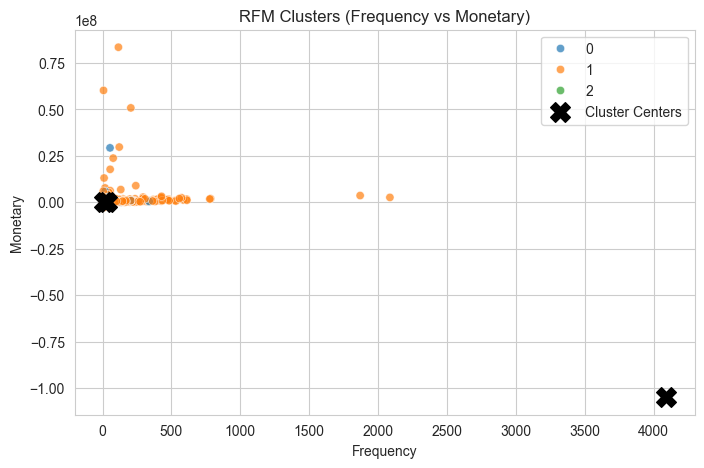

In [7]:
sns.scatterplot(
    data=rfm_labeled,
    x="Frequency",
    y="Monetary",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)

plt.scatter(
    cluster_centers["Frequency"],
    cluster_centers["Monetary"],
    color="black",
    marker="X",
    s=200,
    label="Cluster Centers"
)

plt.title("RFM Clusters (Frequency vs Monetary)")
plt.legend()
plt.show()


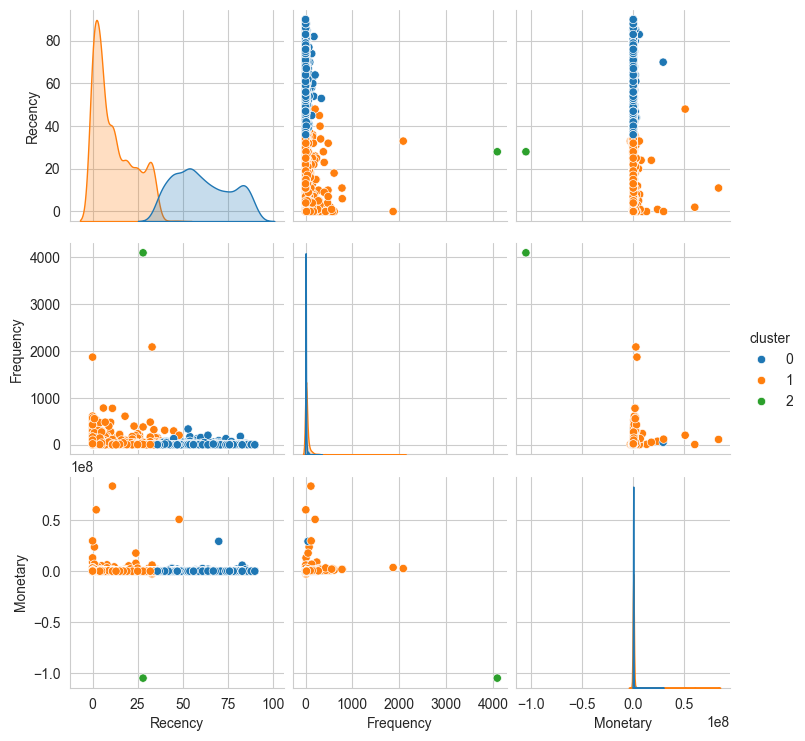

In [8]:
sns.pairplot(
    rfm_labeled,
    vars=["Recency", "Frequency", "Monetary"],
    hue="cluster",
    palette="tab10",
    diag_kind="kde"
)
plt.show()


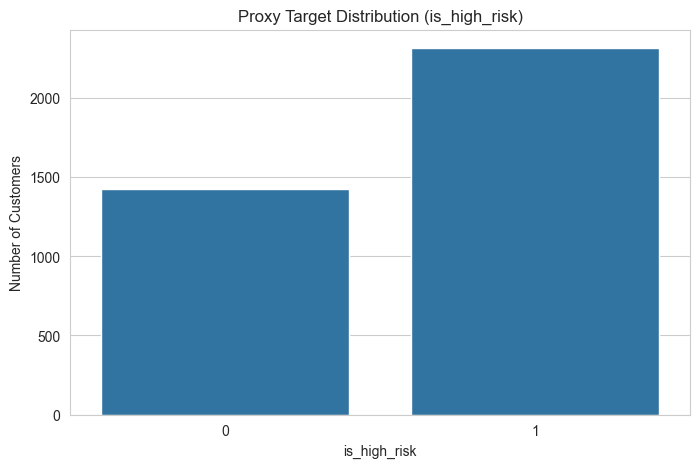

is_high_risk
1    0.618653
0    0.381347
Name: proportion, dtype: float64

In [9]:
sns.countplot(x="is_high_risk", data=rfm_labeled)
plt.title("Proxy Target Distribution (is_high_risk)")
plt.xlabel("is_high_risk")
plt.ylabel("Number of Customers")
plt.show()

rfm_labeled["is_high_risk"].value_counts(normalize=True)


The class distribution is logged for auditability.
Due to conservative risk assignment, the high-risk class represents
a minority of customers, consistent with real-world risk modeling.


In [10]:
features_with_target.head()
features_with_target.shape
# features_with_target["is_high_risk"].value_counts(normalize=True)

(3742, 64)

The final analytics base table contains:
- Customer-level engineered features (Task 3)
- Binary proxy target (`is_high_risk`)
This dataset is ready for supervised modeling.


In [11]:
rfm_labeled[["CustomerId", "is_high_risk"]].to_csv(
    "../data/processed/rfm_labels.csv", index=False
)

features_with_target.to_csv(
    "../data/processed/features_with_target.csv", index=False
)


Due to the absence of reliable and sufficiently frequent fraud labels, a proxy target variable was engineered using customer behavioral segmentation. RFM (Recency, Frequency, Monetary) metrics were calculated at the customer level using a consistent snapshot date. Customers were standardized and clustered using K-Means (k=3) to identify distinct behavioral groups. The cluster exhibiting high recency, low transaction frequency, and low monetary value was labeled as high risk. This binary proxy target (is_high_risk) was merged with engineered features from Task 3 to create a modeling-ready dataset. All steps are fully reproducible, auditable, and aligned with industry best practices for risk modeling.